# 03a - BigQuery ML (BQML) - Logistic Regression For Classification


In this notebook, BigQuery ML (BQML) is used to create a logistic regression model.

**Logistic Regression**

Logistic Regression is a statistical model for the probability, `p`, of a class.  This is accomplished by fitting a linear combination of the features to the log-odds of the class.  The log-odds is called the logit and is the logarithm ($ln$) of the odds ($\frac{p}{1-p}$).  This is a supervised learning approach where the labels, classes, are learned as function of the features.  While the model is estimating the probability of a class `p` which might be considered regression, the probabilities are used to assign a class which is classification.



---
## Setup

inputs:

In [1]:
import os
GOOGLE_APPLICATION_CREDENTIALS = "/Users/zacharynguyen/Documents/GitHub/2024/End-to-End-Vertex-AI-Pipeline-for-Fraud-Detection/key/e2e-fraud-detection-debf1c9863af.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_APPLICATION_CREDENTIALS

In [2]:
PROJECT_ID = 'e2e-fraud-detection'
REGION = 'us-central1'
EXPERIMENT = 'logistic-regression'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud_dataset'
BQ_TABLE = 'prepped-data'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [6]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [7]:
query = f"""
    SELECT splits, {VAR_TARGET}, count(*) as n
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    GROUP BY splits, {VAR_TARGET}
"""
print(query)


    SELECT splits, Class, count(*) as n
    FROM `e2e-fraud-detection.fraud_dataset.prepped-data`
    GROUP BY splits, Class


In [8]:
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28435
1,TEST,1,46
2,TRAIN,0,227497
3,TRAIN,1,400
4,VALIDATE,0,28383
5,VALIDATE,1,46


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [9]:
query = f"""
    WITH
        COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})

    SELECT *,
        SUM(n) OVER() as total,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
        SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
    FROM COUNTS
"""
print(query)


    WITH
        COUNTS as (SELECT splits, Class, count(*) as n FROM `e2e-fraud-detection.fraud_dataset.prepped-data` GROUP BY splits, Class)

    SELECT *,
        SUM(n) OVER() as total,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY Class)) as n_pct_class,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
        SAFE_DIVIDE(SUM(n) OVER(PARTITION BY Class), SUM(n) OVER()) as class_pct_total
    FROM COUNTS


In [10]:
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,VALIDATE,0,28383,284807,0.099829,0.998382,0.998273
1,VALIDATE,1,46,284807,0.093496,0.001618,0.001727
2,TEST,0,28435,284807,0.100012,0.998385,0.998273
3,TEST,1,46,284807,0.093496,0.001615,0.001727
4,TRAIN,0,227497,284807,0.800158,0.998245,0.998273
5,TRAIN,1,400,284807,0.813008,0.001755,0.001727


---
## This Run

In [12]:
print(f'This run will create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'This run will create Vertex AI model: {BQ_PROJECT}.{BQ_DATASET}.{SERIES}_{EXPERIMENT}')
print(f'The runs timestamp Is: {TIMESTAMP}')

This run will create BQML model: e2e-fraud-detection.fraud_dataset.bqml_logistic-regression_20240316092315
This run will create Vertex AI model: e2e-fraud-detection.fraud_dataset.bqml_logistic-regression
The runs timestamp Is: 20240316092315


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

In [13]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        calculate_p_values = TRUE,
        CATEGORY_ENCODING_METHOD = 'DUMMY_ENCODING',
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = '{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
print(query)


CREATE OR REPLACE MODEL `e2e-fraud-detection.fraud_dataset.bqml_logistic-regression_20240316092315`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        calculate_p_values = TRUE,
        CATEGORY_ENCODING_METHOD = 'DUMMY_ENCODING',
        input_label_cols = ['Class'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_logistic-regression',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20240316092315']
    ) AS
SELECT * EXCEPT(transaction_id, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `e2e-fraud-detection.fraud_dataset.prepped-data`
WHERE splits != 'TEST'


In [14]:
job = bq.query(query = query)
job.result()

In [15]:
(job.ended-job.started).total_seconds()

193.462

In [16]:
job.total_bytes_processed

72682591

Add labels to the model in BigQuery:

In [17]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}','timestamp' : f'{TIMESTAMP}'}
model = bq.update_model(model, ['labels'])

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [18]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=e2e-fraud-detection


In [19]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=e2e-fraud-detection&ws=!1m5!1m4!5m3!1se2e-fraud-detection!2sfraud_dataset!3sbqml_logistic-regression_20240316092315


### Check out this model in the Vertex AI Model Registry

In [20]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_bqml_logistic-regression_20240316092315?project=e2e-fraud-detection


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [21]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94822.243593,85960.000000,47468.021107,<NA>,0,<NA>
1,V1,-56.407510,2.446505,-0.000736,0.027965,1.960462,<NA>,0,<NA>
2,V2,-72.715728,22.057729,-0.000056,0.078188,1.654712,<NA>,0,<NA>
3,V3,-32.965346,9.382558,0.000062,0.185541,1.513369,<NA>,0,<NA>
4,V4,-5.683171,16.875344,0.002923,-0.030966,1.417278,<NA>,0,<NA>
5,V5,-42.147898,34.801666,0.002895,-0.056720,1.362772,<NA>,0,<NA>
6,V6,-26.160506,23.917837,-0.002217,-0.273283,1.324232,<NA>,0,<NA>
7,V7,-43.557242,44.054461,0.001489,0.036336,1.214252,<NA>,0,<NA>
8,V8,-73.216718,20.007208,-0.000523,0.021653,1.193520,<NA>,0,<NA>
9,V9,-13.434066,15.594995,-0.001416,-0.060086,1.098525,<NA>,0,<NA>


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [22]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.682802,0.686216,0.2,9035
1,0,1,0.644327,0.647838,0.4,9373
2,0,2,0.575911,0.579565,0.8,8807
3,0,3,0.467513,0.471337,1.6,10159
4,0,4,0.330227,0.334226,3.2,9269
5,0,5,0.211390,0.215643,6.4,8965
6,0,6,0.151702,0.156511,12.8,10350
7,0,7,0.112325,0.117264,25.6,10999


Plot the loss history:

<Axes: xlabel='iteration'>

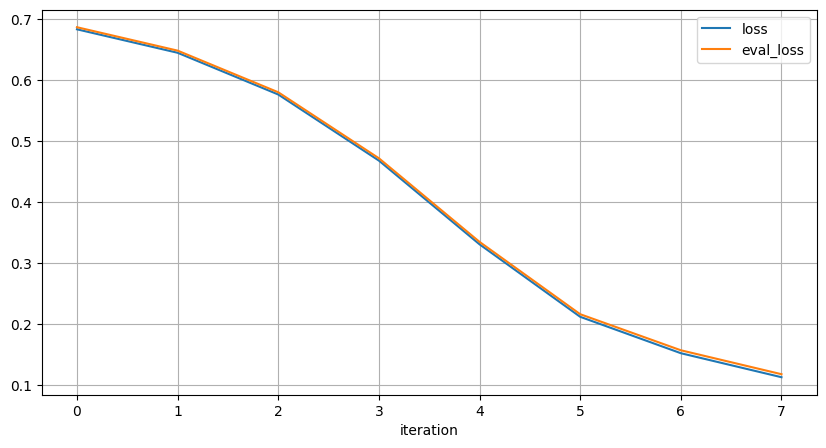

In [23]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Model Weights Review

Retrieve the model parameters with [ML.WEIGHTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-weights).

In [24]:
weights = bq.query(
    query = f"""
        SELECT *
        FROM ML.WEIGHTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    """
).to_dataframe()
weights

,processed_input,weight,category_weights
0,Time,-0.000006,[]
1,V1,0.009915,[]
2,V2,0.032729,[]
3,V3,-0.151392,[]
4,V4,0.562450,[]
5,V5,0.115395,[]
6,V6,-0.180883,[]
7,V7,0.001054,[]
8,V8,-0.187624,[]
9,V9,-0.116906,[]


This logistic regression model was trained with the option`calculate_p_values = TRUE` so the [ML.ADVANCED_WEIGHTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-advanced-weights) function can be used to retireve weights with associated p-values:

In [25]:
weights = bq.query(
    query = f"""
        SELECT *
        FROM ML.ADVANCED_WEIGHTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    """
).to_dataframe()
weights

,processed_input,category,weight,standard_error,p_value
0,Time,None,-0.000006,2.343172e-07,4.440892e-16
1,V1,None,0.009915,1.388515e-02,4.750656e-01
2,V2,None,0.032729,1.597660e-02,4.017918e-02
3,V3,None,-0.151392,2.932818e-02,7.677315e-06
4,V4,None,0.562450,1.776576e-02,0.000000e+00
5,V5,None,0.115395,2.131419e-02,4.062894e-06
6,V6,None,-0.180883,1.033163e-02,8.060219e-14
7,V7,None,0.001054,3.852621e-02,9.784139e-01
8,V8,None,-0.187624,1.168485e-02,3.164136e-13
9,V9,None,-0.116906,1.996049e-02,1.384866e-06


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [26]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,0.086598,0.913043,0.984277,0.158192,0.117263,0.991805
1,TEST,0.084388,0.869565,0.984551,0.153846,0.110271,0.978643
2,TRAIN,0.096577,0.910000,0.984901,0.174622,0.112325,0.985369


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [27]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,224092,3405
1,1,36,364


In [28]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,27940,443
1,1,4,42


In [29]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28001,434
1,1,6,40


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [30]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.0200,0.000000,8,0,227497,392
1,0.655591,0.8925,0.008624,357,1962,225535,43
2,0.452014,0.9200,0.018541,368,4218,223279,32
3,0.370221,0.9250,0.028290,370,6436,221061,30
4,0.319897,0.9350,0.038370,374,8729,218768,26


In [31]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.021739,0.000000,1,0,28383,45
1,0.680289,0.847826,0.008597,39,244,28139,7
2,0.459541,0.913043,0.018673,42,530,27853,4
3,0.369913,0.956522,0.028609,44,812,27571,2
4,0.322698,0.956522,0.038544,44,1094,27289,2


In [32]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.043478,0.000000,2,0,28435,44
1,0.665312,0.847826,0.008827,39,251,28184,7
2,0.452143,0.869565,0.018780,40,534,27901,6
3,0.374490,0.869565,0.028556,40,812,27623,6
4,0.319276,0.869565,0.038790,40,1103,27332,6


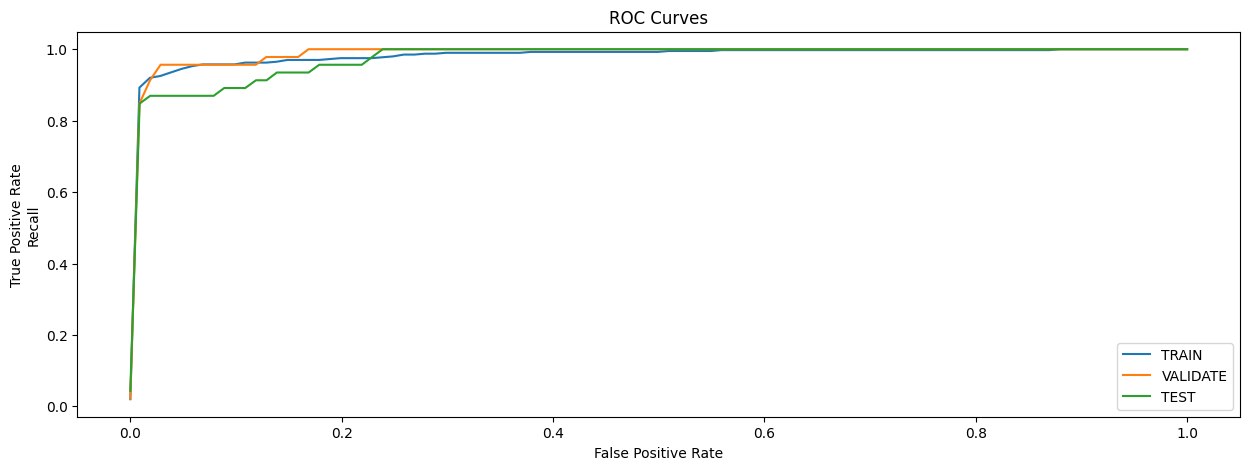

In [33]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [34]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [35]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [36]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.1075252936911701}, {'l...",TEST
1,0,0,"[{'label': 1, 'prob': 0.24131627035963504}, {'...",TEST
2,0,0,"[{'label': 1, 'prob': 0.11756581347047092}, {'...",TEST
3,0,0,"[{'label': 1, 'prob': 0.18860839162234785}, {'...",TEST
4,0,0,"[{'label': 1, 'prob': 0.1283615890983487}, {'l...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prob`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [37]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.8924747063088299},
  {'label': 1, 'prob': 0.1075252936911701}]]

---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [38]:
metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

array([[28001,   434],
       [    6,    40]])

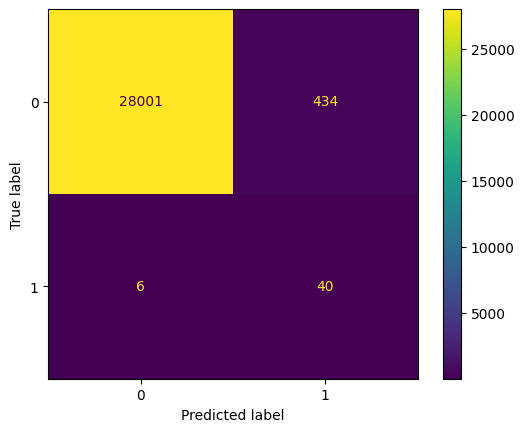

In [39]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [40]:
metrics.accuracy_score(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

0.9845511042449352

In [41]:
print(metrics.classification_report(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28435
           1       0.08      0.87      0.15        46

    accuracy                           0.98     28481
   macro avg       0.54      0.93      0.57     28481
weighted avg       1.00      0.98      0.99     28481


---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [42]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [43]:
explain.head()

,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,V3,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,0,0.892475,"[{'feature': 'V4', 'attribution': 2.1859897110...",-2.737137,-2.116272,0.0,140315.0,1.882751,0.532175,0.150708,...,0.487635,-0.024250,-0.512936,-0.516050,0.011179,-0.026608,0.0,0,007bcd38-0860-4140-8182-f1a19fea3aa7,TEST
1,0,0.758684,"[{'feature': 'V4', 'attribution': 2.5102084227...",-2.737137,-1.145477,0.0,171011.0,-1.345222,2.280635,2.149265,...,-0.201321,0.007053,0.055551,0.580323,-0.086456,-0.050837,0.0,0,da201b45-1c71-410e-9cb9-d3bfc82b2a15,TEST
2,0,0.882434,"[{'feature': 'V14', 'attribution': 0.547825872...",-2.737137,-2.015686,0.0,35734.0,-2.571353,-2.286027,2.909699,...,-0.363365,-0.520853,-0.024029,1.180507,-0.309633,-0.296332,0.0,0,47357783-5339-4ede-91f5-5ff57cbb11cd,TEST
3,0,0.811392,"[{'feature': 'V4', 'attribution': 1.5487438098...",-2.737137,-1.459078,0.0,12973.0,1.042687,0.224056,1.651554,...,0.082059,-0.072716,0.148948,-0.066969,0.024569,0.014142,0.0,0,db700585-1fc5-4747-858e-1c36de09ec2a,TEST
4,0,0.871638,"[{'feature': 'V12', 'attribution': 0.762221531...",-2.737137,-1.915523,0.0,64268.0,1.316193,-0.009926,-0.137555,...,-0.136149,-0.126894,0.639381,0.595106,-0.070506,-0.010366,0.0,0,72eaec6f-9f06-4d5c-8983-27535cee2b35,TEST


Create a plot of feature attributions for a single prediction:

In [44]:
explanation = explain.iloc[0]['top_feature_attributions']

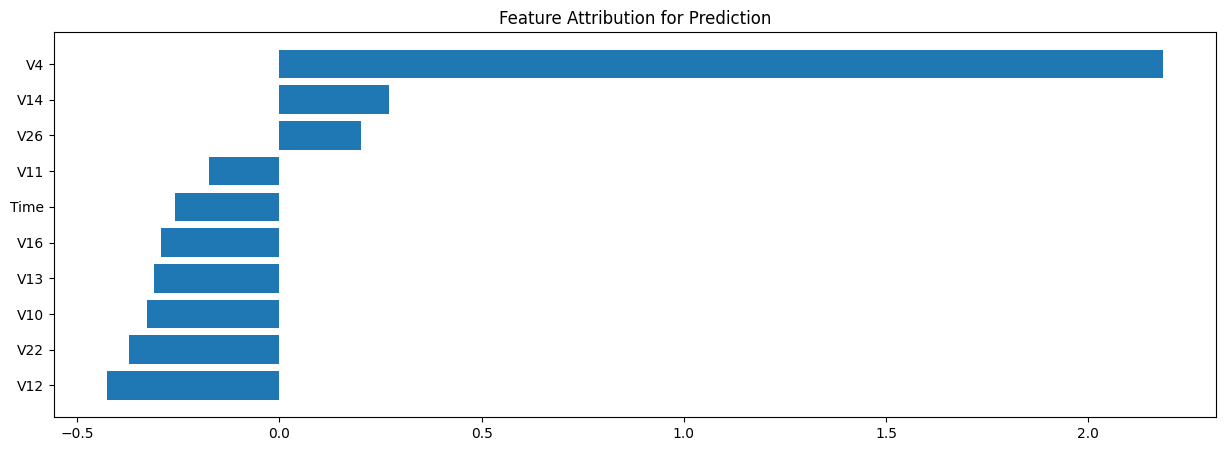

In [45]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [46]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [47]:
gexplain.head()

,feature,attribution
0,V4,0.609498
1,V14,0.454990
2,V12,0.435927
3,Time,0.248053
4,V16,0.231627


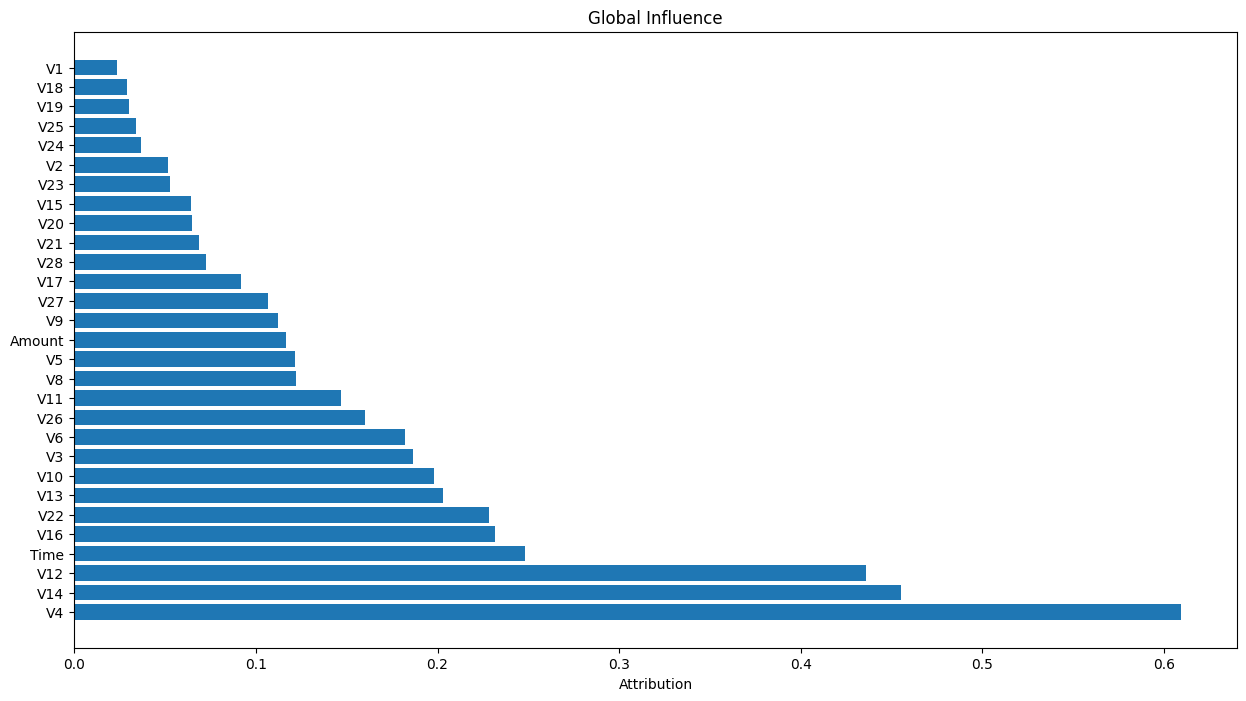

In [48]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

The training options for creating the model include registering the model the Vertex AI Automatically.  This makes deploying the model to a [Vertex AI Endpoint for online serving](https://cloud.google.com/vertex-ai/docs/general/deployment) very easy.

### Vertex AI Model Registry - Get Model

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model using the [Vertex AI Python Client](../Tips/aiplatform_notes.md).

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [50]:
vertex_model = aiplatform.Model(model_name = f'{SERIES}_{EXPERIMENT}')
vertex_model.resource_name

'projects/993073267534/locations/us-central1/models/bqml_logistic-regression'

In [51]:
aiplatform.ModelEvaluation(
    evaluation_name = vertex_model.get_model_evaluation().resource_name
).to_dict()['metrics']['confusionMatrix']

{'rows': [[42.0, 4.0], [532.0, 27851.0]],
 'annotationSpecs': [{'displayName': '1', 'id': '0'},
  {'displayName': '0', 'id': '1'}]}

In [52]:
# note: this is blank since the model is managed by BQML and container is pre-specified
vertex_model.uri 

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [53]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

Creating Endpoint
Create Endpoint backing LRO: projects/993073267534/locations/us-central1/endpoints/5892812777856172032/operations/5633617239618879488
Endpoint created. Resource name: projects/993073267534/locations/us-central1/endpoints/5892812777856172032
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/993073267534/locations/us-central1/endpoints/5892812777856172032')
Endpoint Created: bqml


In [54]:
endpoint.display_name

'bqml'

In [55]:
endpoint.traffic_split

{}

In [56]:
deployed_models = endpoint.list_models()
deployed_models

[]

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

### UI Manual 

In [59]:
#endpoint.deploy(
#    model = vertex_model,
#    deployed_model_display_name = vertex_model.display_name,
#    traffic_percentage = 100,
#    machine_type = 'n1-standard-2',
#    min_replica_count = 1,
#    max_replica_count = 1
#)

In [64]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

Endpoint Found: bqml


In [65]:
endpoint.list_models()

[dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 id: "2082859852077465600"
 model: "projects/993073267534/locations/us-central1/models/bqml_logistic-regression"
 model_version_id: "1"
 display_name: "bqml_logistic-regression"
 create_time {
   seconds: 1710600641
   nanos: 154889000
 }
 service_account: "zacharynguyen@e2e-fraud-detection.iam.gserviceaccount.com"
 disable_container_logging: true
 enable_access_logging: true]

### Remove Deployed Models without Traffic

In [66]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model bqml_logistic-regression with version 1 has traffic = 100


In [67]:
endpoint.traffic_split

{'2082859852077465600': 100}

In [68]:
#endpoint.list_models()

---
## Predictions With Vertex AI Endpoint

### Retrieve Records For Prediction

In [73]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM `{PROJECT_ID}.{BQ_DATASET}.prepped-data`
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

Shape as instances: dictionaries of key:value pairs for only features used in model

In [74]:
newobs = pred.to_dict(orient = 'records')

In [75]:
newobs[0]

{'Time': 140315.0,
 'V1': 1.88275144365981,
 'V2': 0.5321745574787371,
 'V3': 0.150708356622915,
 'V4': 3.8894693444449104,
 'V5': 0.0110367165296031,
 'V6': 0.10161692045463001,
 'V7': -0.105079317724247,
 'V8': -0.0276783367013348,
 'V9': -0.649422331552985,
 'V10': 1.2760161964761398,
 'V11': -1.0975780754147801,
 'V12': 0.7253332584452471,
 'V13': 1.30091293887403,
 'V14': -0.404936212520168,
 'V15': -1.26229079100372,
 'V16': 0.872501700920738,
 'V17': -0.762329639638684,
 'V18': -0.954372139279484,
 'V19': -1.26536709127823,
 'V20': -0.22555835884440698,
 'V21': -0.401006076766849,
 'V22': -1.01558064776831,
 'V23': 0.487634612397945,
 'V24': -0.0242502150262368,
 'V25': -0.512936399003697,
 'V26': -0.51604963380311,
 'V27': 0.0111793306485451,
 'V28': -0.0266076514394325,
 'Amount': 0.0}

### Get Predictions: Python Client

In [76]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

Prediction(predictions=[{'predicted_Class': ['0'], 'Class_values': ['1', '0'], 'Class_probs': [0.107525295341668, 0.892474704658332]}], deployed_model_id='2082859852077465600', model_version_id='1', model_resource_name='projects/993073267534/locations/us-central1/models/bqml_logistic-regression', explanations=None)

In [77]:
prediction.predictions[0]

{'predicted_Class': ['0'],
 'Class_values': ['1', '0'],
 'Class_probs': [0.107525295341668, 0.892474704658332]}

In [78]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:predict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_predict)

Prepare request:

In [79]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [80]:
prediction = !curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '100  1231    0   438  100   793   1614   2922 --:--:-- --:--:-- --:--:--  4542',
 '{',
 '  "predictions": [',
 '    {',
 '      "Class_values": [',
 '        "1",',
 '        "0"',
 '      ],',
 '      "predicted_Class": [',
 '        "0"',
 '      ],',
 '      "Class_probs": [',
 '        0.107525295341668,',
 '        0.892474704658332',
 '      ]',
 '    }',
 '  ],',
 '  "deployedModelId": "2082859852077465600",',
 '  "model": "projects/993073267534/locations/us-central1/models/bqml_logistic-regression",',
 '  "modelDisplayName": "bqml_logistic-regression",',
 '  "modelVersionId": "1"',
 '}']

Format raw prediction response using JSON:

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict)

Prepare request:

In [81]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [82]:
prediction = !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json
prediction

['You do not currently have this command group installed.  Using it ',
 'requires the installation of components: [beta]',
 '',
 '',
 'Your current Google Cloud CLI version is: 463.0.0',
 'Installing components from version: 463.0.0',
 '',
 '┌─────────────────────────────────────────────┐',
 '│     These components will be installed.     │',
 '├──────────────────────┬────────────┬─────────┤',
 '│         Name         │  Version   │   Size  │',
 '├──────────────────────┼────────────┼─────────┤',
 '│ gcloud Beta Commands │ 2024.02.02 │ < 1 MiB │',
 '└──────────────────────┴────────────┴─────────┘',
 '',
 'For the latest full release notes, please visit:',
 '  https://cloud.google.com/sdk/release_notes',
 '',
 'Do you want to continue (Y/n)?  ',
 'ERROR: (gcloud) This prompt could not be answered because you are not in an interactive session.  You can re-run the command with the --quiet flag to accept default answers for all prompts.']

---
## Export Model

The model created in BigQuery ML can be exported to their native model types save files.  This process saves the model artifacts in GCS where they can be use anywhere they are needed.  For instance, they could be imported into the Vertex AI Model Registry for use in online and batch serving - however, this process is automated with the training options use above.

### Export the BigQuery Model


The models trained in BQML can be exported from BigQuery to GCS:

Reference:
- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [83]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [84]:
(export.ended - export.started).total_seconds()

17.754

In [85]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/e2e-fraud-detection/bqml/logistic-regression/models/20240316092315/model?project=e2e-fraud-detection


### Detect The Model Types Framework

In [88]:
def determine_model_framework(bucket_name, prefix, service_account_path):
    """
    Lists objects in a specified GCS bucket path, identifies model framework based on file extensions,
    and ensures a single model framework is present.

    Args:
        bucket_name (str): The name of the GCS bucket.
        prefix (str): The GCS path prefix to list objects from.
        service_account_path (str): The file path to the service account key file.
    
    Returns:
        The model framework if determined uniquely, otherwise raises an error.
    """
    from google.oauth2 import service_account
    from google.cloud import storage
    # Authenticate with the service account
    credentials = service_account.Credentials.from_service_account_file(service_account_path)
    storage_client = storage.Client(credentials=credentials)
    bucket = storage_client.bucket(bucket_name)

    # Mapping of file extensions to model frameworks
    filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

    # List objects in the bucket with the specified prefix
    blobs = bucket.list_blobs(prefix=prefix)
    filenames = [blob.name for blob in blobs]

    # Determine model frameworks based on file extensions in the listing
    filetypes = [filetype[os.path.splitext(f)[1][1:]] for f in filenames if os.path.splitext(f)[1][1:] in filetype]

    # Ensure a single model framework is present
    if len(set(filetypes)) == 1:
        framework = filetypes[0]
        print(f'Model framework determined: {framework}')
        return framework
    else:
        error_msg = f"Model Type Undetermined! Multiple or no model frameworks found: {set(filetypes)}"
        raise TypeError(error_msg)

# Example usage
bucket_name = BUCKET
prefix = f'{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model'
service_account_path = GOOGLE_APPLICATION_CREDENTIALS

try:
    framework = determine_model_framework(bucket_name, prefix, service_account_path)
except TypeError as e:
    print(e)


Model framework determined: TensorFlow


---
## Remove Resources

The following cells have commented out statements that can be used to remove resources created by this notebook.  Other notebooks in the repository will reusue the same endpoint so it may be desired to not remove the endpoint if you plan to run additional notebooks.  Otherwise, please removed the endpoint to prevent ongoing cost from hosting the models on Vertex AI Endpoints.

Similarly, if you want to remove the model from BQML to prevent the minimal storage cost it will automatically be removed from Vertex AI Model Registry as well.

In [87]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
#endpoint.delete(force = True)

In [ ]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
#bq.delete_model(model)